In [49]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **IMPORTS**

Make all the necessary Imports here

In [50]:
%tensorflow_version 1.x

In [51]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import cv2

In [52]:
import os
import datetime
import math
import random
from random import shuffle

In [53]:
import tensorflow

In [54]:
print(tensorflow.__version__)

1.15.2


In [55]:
import keras
from keras.utils import Sequence
import keras.backend as K

In [56]:
from keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, ZeroPadding2D, MaxPooling2D, Concatenate, Reshape, Lambda, Multiply
from keras.engine.topology import Layer

In [57]:
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [58]:
print(keras.__version__)

2.3.1


## **PATHS AND VARIABLES**

Define relevent paths and variables

In [59]:
os.getcwd()

'/content'

In [60]:
img_rows, img_cols = 320, 320
# img_rows_half, img_cols_half = 160, 160
channel = 4
batch_size = 16
epochs = 1000
patience = 50
num_samples = 14654

unknown_code = 128
epsilon = 1e-6
epsilon_sqr = epsilon ** 2

In [61]:
# path to provided foreground images
#should end in a '/', all of them
fg_path = '/content/gdrive/My Drive/DIM/fg/'

# path to provided alpha mattes
a_path = '/content/gdrive/My Drive/DIM/alpha/'

# Path to background images (MSCOCO)
bg_path = '/content/gdrive/My Drive/DIM/bg/'

# Path to folder where you want the composited images to go
out_path = '/content/gdrive/My Drive/DIM/merged/'

In [62]:
checkpoint_path = '/content/gdrive/My Drive/DIM/models/'

## **FUNCTIONS AND PREPROCESSING**

Create all the Classes and Functions to be used later

In [63]:
def overall_loss(y_true, y_pred):
    w_l = 0.5
    return w_l * alpha_prediction_loss(y_true, y_pred) + (1 - w_l) * compositional_loss(y_true, y_pred)

In [64]:
def alpha_prediction_loss(y_true, y_pred):
    mask = y_true[:, :, :, 1]
    diff = y_pred[:, :, :, 0] - y_true[:, :, :, 0]
    diff = diff * mask
    num_pixels = K.sum(mask)
    return K.sum(K.sqrt(K.square(diff) + epsilon_sqr)) / (num_pixels + epsilon)

In [65]:
def compositional_loss(y_true, y_pred):
    mask = y_true[:, :, :, 1]
    mask = K.reshape(mask, (-1, img_rows, img_cols, 1))
    image = y_true[:, :, :, 2:5]
    fg = y_true[:, :, :, 5:8]
    bg = y_true[:, :, :, 8:11]
    c_g = image
    c_p = y_pred * fg + (1.0 - y_pred) * bg
    diff = c_p - c_g
    diff = diff * mask
    num_pixels = K.sum(mask)
    return K.sum(K.sqrt(K.square(diff) + epsilon_sqr)) / (num_pixels + epsilon)

In [66]:
# def compute_mse_loss(pred, target, trimap):
#     error_map = (pred - target) / 255.
#     mask = np.equal(trimap, unknown_code).astype(np.float32)
#     # print('unknown: ' + str(unknown))
#     loss = np.sum(np.square(error_map) * mask) / np.sum(mask)
#     # print('mse_loss: ' + str(loss))
#     return loss

In [118]:
def compute_mse_loss(pred, target, trimap):
    # pred = pred / (pred.max())
    # target = target / (target.max())
    # trimap = trimap / (trimap.max())
    error_map = (pred - target)
    mask = np.equal(trimap, unknown_code).astype(np.float32)
    # print('unknown: ' + str(unknown))
    loss = np.sum(np.square(error_map) * mask) / np.sum(mask)
    # print('mse_loss: ' + str(loss))
    return loss

In [67]:
def compute_sad_loss(pred, target, trimap):
    error_map = np.abs(pred - target) / 255.
    mask = np.equal(trimap, unknown_code).astype(np.float32)
    loss = np.sum(error_map * mask)

    # the loss is scaled by 1000 due to the large images used in our experiment.
    loss = loss / 1000
    # print('sad_loss: ' + str(loss))
    return loss

In [68]:
def get_final_output(out, trimap):
    mask = np.equal(trimap, unknown_code).astype(np.float32)
    return (1 - mask) * trimap + mask * out

In [69]:
def patch_dims(mat_size, patch_size):
    return np.ceil(np.array(mat_size) / patch_size).astype(int)

In [70]:
def create_patches(mat, patch_size):
    mat_size = mat.shape
    assert len(mat_size) == 3, "Input mat need to have 4 channels (R, G, B, trimap)"
    assert mat_size[-1] == 4 , "Input mat need to have 4 channels (R, G, B, trimap)"

    patches_dim = patch_dims(mat_size=mat_size[:2], patch_size=patch_size)
    patches_count = np.product(patches_dim)

    patches = np.zeros(shape=(patches_count, patch_size, patch_size, 4), dtype=np.float32)
    for y in range(patches_dim[0]):
        y_start = y * patch_size
        for x in range(patches_dim[1]):
            x_start = x * patch_size

            # extract patch from input mat
            single_patch = mat[y_start: y_start + patch_size, x_start: x_start + patch_size, :]

            # zero pad patch in bottom and right side if real patch size is smaller than patch size
            real_patch_h, real_patch_w = single_patch.shape[:2]
            patch_id = y + x * patches_dim[0]
            patches[patch_id, :real_patch_h, :real_patch_w, :] = single_patch

    return patches

In [71]:
def assemble_patches(pred_patches, mat_size, patch_size):
    patch_dim_h, patch_dim_w = patch_dims(mat_size=mat_size, patch_size=patch_size)
    result = np.zeros(shape=(patch_size * patch_dim_h, patch_size * patch_dim_w), dtype=np.uint8)
    patches_count = pred_patches.shape[0]

    for i in range(patches_count):
        y = (i % patch_dim_h) * patch_size
        x = int(math.floor(i / patch_dim_h)) * patch_size

        result[y:y+patch_size, x:x+patch_size] = pred_patches[i]

    return result

In [72]:
def safe_crop(mat, x, y, crop_size=(img_rows, img_cols)):
    crop_height, crop_width = crop_size
    if len(mat.shape) == 2:
        ret = np.zeros((crop_height, crop_width), np.float32)
    else:
        ret = np.zeros((crop_height, crop_width, 3), np.float32)
    crop = mat[y:y + crop_height, x:x + crop_width]
    h, w = crop.shape[:2]
    ret[0:h, 0:w] = crop
    if crop_size != (img_rows, img_cols):
        ret = cv2.resize(ret, dsize=(img_rows, img_cols), interpolation=cv2.INTER_NEAREST)
    return ret

In [73]:
def get_alpha(name):
    filename = '/content/gdrive/My Drive/DIM/alpha/{}.jpg'.format(name)
    alpha = cv2.imread(filename, 0)
    return alpha

In [74]:
def composite4(fg, bg, a, w, h):
    fg = np.array(fg, np.float32)
    bg_h, bg_w = bg.shape[:2]
    x = 0
    if bg_w > w:
        x = np.random.randint(0, bg_w - w)
    y = 0
    if bg_h > h:
        y = np.random.randint(0, bg_h - h)
    bg = np.array(bg[y:y + h, x:x + w], np.float32)
    alpha = np.zeros((h, w, 1), np.float32)
    alpha[:, :, 0] = a / 255.
    im = alpha * fg + (1 - alpha) * bg
    im = im.astype(np.uint8)
    return im, a, fg, bg

In [75]:
def process(im_name, bg_name):
    im = cv2.imread('{}/{}.jpg'.format(fg_path,im_name))
    im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
    a = cv2.imread('{}/{}.jpg'.format(a_path,im_name), 0)
    h, w = im.shape[:2]
    bg = cv2.imread('{}/{}.jpg'.format(bg_path,bg_name))
    bh, bw = bg.shape[:2]
    wratio = w / bw
    hratio = h / bh
    ratio = wratio if wratio > hratio else hratio
    if ratio > 1:
        bg = cv2.resize(src=bg, dsize=(math.ceil(bw * ratio), math.ceil(bh * ratio)), interpolation=cv2.INTER_CUBIC)

    return composite4(im, bg, a, w, h)

In [76]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

In [77]:
def generate_trimap(alpha):
    fg = np.array(np.equal(alpha, 255).astype(np.float32))
    # fg = cv.erode(fg, kernel, iterations=np.random.randint(1, 3))
    unknown = np.array(np.not_equal(alpha, 0).astype(np.float32))
    unknown = cv2.dilate(unknown, kernel, iterations=np.random.randint(1, 20))
    trimap = fg * 255 + (unknown - fg) * 128
    return trimap.astype(np.uint8)

In [78]:
def random_choice(trimap, crop_size=(320, 320)):
    crop_height, crop_width = crop_size
    y_indices, x_indices = np.where(trimap == unknown_code)
    num_unknowns = len(y_indices)
    x, y = 0, 0
    if num_unknowns > 0:
        ix = np.random.choice(range(num_unknowns))
        center_x = x_indices[ix]
        center_y = y_indices[ix]
        x = max(0, center_x - int(crop_width / 2))
        y = max(0, center_y - int(crop_height / 2))
    return x, y

In [79]:
class DataGenSequence(Sequence):
    def __init__(self, usage):
        self.usage = usage

        filename = '/content/gdrive/My Drive/DIM/{}.txt'.format(usage)
        with open(filename, 'r') as f:
            self.names = f.read().splitlines()

        np.random.shuffle(self.names)

    def __len__(self):
        return int(np.ceil(len(self.names) / float(batch_size)))

    def __getitem__(self, idx):
        i = idx * batch_size

        length = min(batch_size, (len(self.names) - i))
        batch_x = np.empty((length, img_rows, img_cols, 4), dtype=np.float32)
        batch_y = np.empty((length, img_rows, img_cols, 11), dtype=np.float32)

        for i_batch in range(length):
            name = self.names[i]
            im_name = name.split('_')[0]
            bg_name = name.split('_')[1]
            image, alpha, fg, bg = process(im_name, bg_name)

            # crop size 320:640:480 = 1:1:1
            different_sizes = [(320, 320), (480, 480), (640, 640)]
            crop_size = random.choice(different_sizes)

            trimap = generate_trimap(alpha)
            x, y = random_choice(trimap, crop_size)
            image = safe_crop(image, x, y, crop_size)
            alpha = safe_crop(alpha, x, y, crop_size)
            fg = safe_crop(fg, x, y, crop_size)
            bg = safe_crop(bg, x, y, crop_size)

            trimap = generate_trimap(alpha)

            # Flip array left to right randomly (prob=1:1)
            if np.random.random_sample() > 0.5:
                image = np.fliplr(image)
                trimap = np.fliplr(trimap)
                alpha = np.fliplr(alpha)
                fg = np.fliplr(fg)
                bg = np.fliplr(bg)

            batch_x[i_batch, :, :, 0:3] = image / 255.
            batch_x[i_batch, :, :, 3] = trimap / 255.

            mask = np.equal(trimap, 128).astype(np.float32)
            batch_y[i_batch, :, :, 0] = alpha / 255.
            batch_y[i_batch, :, :, 1] = mask
            batch_y[i_batch, :, :, 2:5] = image / 255.
            batch_y[i_batch, :, :, 5:8] = fg / 255.
            batch_y[i_batch, :, :, 8:11] = bg / 255.

            i += 1

        return batch_x, batch_y

    def on_epoch_end(self):
        np.random.shuffle(self.names)

In [80]:
def train_gen(name='train'):
    return DataGenSequence(name)

def valid_gen(name='valid'):
    return DataGenSequence(name)

In [81]:
x = train_gen('train-10')

In [82]:
class Unpooling(Layer):

    def __init__(self, **kwargs):
        super(Unpooling, self).__init__(**kwargs)

    def build(self, input_shape):
        super(Unpooling, self).build(input_shape)

    def call(self, inputs, **kwargs):
        x = inputs[:, 1]
        # print('x.shape: ' + str(K.int_shape(x)))
        bool_mask = Lambda(lambda t: K.greater_equal(t[:, 0], t[:, 1]),
                           output_shape=K.int_shape(x)[1:])(inputs)
        # print('bool_mask.shape: ' + str(K.int_shape(bool_mask)))
        mask = Lambda(lambda t: K.cast(t, dtype='float32'))(bool_mask)
        # print('mask.shape: ' + str(K.int_shape(mask)))
        x = Multiply()([mask, x])
        # print('x.shape: ' + str(K.int_shape(x)))
        return x

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[2], input_shape[3], input_shape[4]

In [83]:
def build_encoder_decoder():
    # Encoder
    input_tensor = Input(shape=(320, 320, 4))
    x = ZeroPadding2D((1, 1))(input_tensor)
    x = Conv2D(64, (3, 3), activation='relu', name='conv1_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(64, (3, 3), activation='relu', name='conv1_2')(x)
    orig_1 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(128, (3, 3), activation='relu', name='conv2_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(128, (3, 3), activation='relu', name='conv2_2')(x)
    orig_2 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(256, (3, 3), activation='relu', name='conv3_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(256, (3, 3), activation='relu', name='conv3_2')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(256, (3, 3), activation='relu', name='conv3_3')(x)
    orig_3 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv4_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv4_2')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv4_3')(x)
    orig_4 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv5_1')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv5_2')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Conv2D(512, (3, 3), activation='relu', name='conv5_3')(x)
    orig_5 = x
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Decoder
    # x = Conv2D(4096, (7, 7), activation='relu', padding='valid', name='conv6')(x)
    # x = BatchNormalization()(x)
    # x = UpSampling2D(size=(7, 7))(x)

    x = Conv2D(512, (1, 1), activation='relu', padding='same', name='deconv6', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    the_shape = K.int_shape(orig_5)
    shape = (1, the_shape[1], the_shape[2], the_shape[3])
    origReshaped = Reshape(shape)(orig_5)
    # print('origReshaped.shape: ' + str(K.int_shape(origReshaped)))
    xReshaped = Reshape(shape)(x)
    # print('xReshaped.shape: ' + str(K.int_shape(xReshaped)))
    together = Concatenate(axis=1)([origReshaped, xReshaped])
    # print('together.shape: ' + str(K.int_shape(together)))
    x = Unpooling()(together)

    x = Conv2D(512, (5, 5), activation='relu', padding='same', name='deconv5', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    the_shape = K.int_shape(orig_4)
    shape = (1, the_shape[1], the_shape[2], the_shape[3])
    origReshaped = Reshape(shape)(orig_4)
    xReshaped = Reshape(shape)(x)
    together = Concatenate(axis=1)([origReshaped, xReshaped])
    x = Unpooling()(together)

    x = Conv2D(256, (5, 5), activation='relu', padding='same', name='deconv4', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    the_shape = K.int_shape(orig_3)
    shape = (1, the_shape[1], the_shape[2], the_shape[3])
    origReshaped = Reshape(shape)(orig_3)
    xReshaped = Reshape(shape)(x)
    together = Concatenate(axis=1)([origReshaped, xReshaped])
    x = Unpooling()(together)

    x = Conv2D(128, (5, 5), activation='relu', padding='same', name='deconv3', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    the_shape = K.int_shape(orig_2)
    shape = (1, the_shape[1], the_shape[2], the_shape[3])
    origReshaped = Reshape(shape)(orig_2)
    xReshaped = Reshape(shape)(x)
    together = Concatenate(axis=1)([origReshaped, xReshaped])
    x = Unpooling()(together)

    x = Conv2D(64, (5, 5), activation='relu', padding='same', name='deconv2', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D(size=(2, 2))(x)
    the_shape = K.int_shape(orig_1)
    shape = (1, the_shape[1], the_shape[2], the_shape[3])
    origReshaped = Reshape(shape)(orig_1)
    xReshaped = Reshape(shape)(x)
    together = Concatenate(axis=1)([origReshaped, xReshaped])
    x = Unpooling()(together)
    x = Conv2D(64, (5, 5), activation='relu', padding='same', name='deconv1', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)

    x = Conv2D(1, (5, 5), activation='sigmoid', padding='same', name='pred', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)

    model = Model(inputs=input_tensor, outputs=x)
    return model

In [84]:
def build_refinement(encoder_decoder):
    input_tensor = encoder_decoder.input

    input = Lambda(lambda i: i[:, :, :, 0:3])(input_tensor)

    x = Concatenate(axis=3)([input, encoder_decoder.output])
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)
    x = BatchNormalization()(x)
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='refinement_pred', kernel_initializer='he_normal',
               bias_initializer='zeros')(x)

    model = Model(inputs=input_tensor, outputs=x)
    return model

## **CALLBACKS**

Initialize all the callbacks here

In [85]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [86]:
logdir = os.path.join("/content/gdrive/My Drive/DIM/logs", datetime.datetime.now().strftime("NEW-%Y%m%d-%H%M%S"))
# tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

In [87]:
checkpoint_models_path = '/content/gdrive/My Drive/DIM/models/'

In [88]:
tensor_board = keras.callbacks.TensorBoard(log_dir='/content/gdrive/My Drive/DIM/logs/', histogram_freq=0, write_graph=True, write_images=True)
model_names = checkpoint_models_path + 'model.{epoch:02d}-{val_loss:.4f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, monitor='val_loss', verbose=1, save_best_only=True)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience / 4), verbose=1)

In [89]:
class MyCbk(keras.callbacks.Callback):
        def __init__(self, model):
            keras.callbacks.Callback.__init__(self)
            self.model_to_save = model

        def on_epoch_end(self, epoch, logs=None):
            fmt = checkpoint_models_path + 'model.%02d-%.4f.hdf5'
            self.model_to_save.save(fmt % (epoch, logs['val_loss']))

## **TRAIN ENCODER DECODER**

Training stage for Encoder-Decoder part

In [43]:
new_model = build_encoder_decoder()
# new_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
# new_model = keras.models.load_model('/content/gdrive/My Drive/DIM/models/first_try.h5')

In [44]:
callbacks = [tensor_board, model_checkpoint, early_stop, reduce_lr]

In [45]:
new_model.load_weights('/content/gdrive/My Drive/DIM/models/model.03-0.1289.hdf5')

In [46]:
new_model.compile(optimizer='nadam', loss=overall_loss)

In [47]:
num_train_samples = 2818
# num_samples - num_train_samples
num_valid_samples = 534

In [48]:
new_model.fit(x = train_gen('train-03'), steps_per_epoch = 2818 // batch_size, validation_data = valid_gen('valid-12'), validation_steps = 534 // batch_size, epochs = 100, verbose = 1, callbacks = callbacks,)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100


/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 108 could not be retrieved. It could be because a worker has died.
  UserWarning)


  2/176 [..............................] - ETA: 2:58:34 - loss: 0.3012

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:616: UserWarning: The input 98 could not be retrieved. It could be because a worker has died.
  UserWarning)


 39/176 [=====>........................] - ETA: 28:46 - loss: 0.2165

KeyboardInterrupt: ignored

In [ ]:
new_model.save_weights('/content/gdrive/My Drive/DIM/models/second3_try.h5')

In [ ]:
print('done')

done


In [ ]:
%tensorboard --logdir /content/gdrive/My Drive/DIM/logs/train

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2020-07-04 15:35:32.764602: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--purge_orphaned_data BOOL] [--db URI] [--db_import]
                   [--inspect] [--version_tb] [--tag TAG] [--event_file PATH]
                   [--path_prefix PATH] [--window_title TEXT]
                   [--max_reload_threads COUNT] [--reload_interval SECONDS]
                   [--reload_task TYPE] [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [--debugger_data_server_grpc_port PORT]
                   [--debugger_port PORT]
                   {se

## **TRAIN REFINEMENT**

Training the refinement stage by loading pre-trained Encoder-Decoder

In [ ]:
pretrained_path = '/content/gdrive/My Drive/DIM/models/model.03-0.1289.hdf5'

In [ ]:
encoder_decoder = build_encoder_decoder()
encoder_decoder.load_weights(pretrained_path)
# fix encoder-decoder part parameters and then update the refinement part.
for layer in encoder_decoder.layers:
    layer.trainable = False

In [ ]:
refinement = build_refinement(encoder_decoder)
# refinement.summary()

In [ ]:
refinement.compile(optimizer='nadam', loss=alpha_prediction_loss)

In [ ]:
callbacks = [tensor_board, model_checkpoint, early_stop, reduce_lr]

In [ ]:
refinement.fit(x = train_gen('train-04'), steps_per_epoch=2818 // batch_size, validation_data=valid_gen('valid-11'), validation_steps=534 // batch_size, epochs=10, verbose=1, callbacks=callbacks)

Epoch 1/10
176/176 [==============================] - 1300s 7s/step - loss: 0.1338 - val_loss: 0.2607

Epoch 00001: val_loss did not improve from 0.12889
Epoch 2/10
176/176 [==============================] - 1308s 7s/step - loss: 0.1195 - val_loss: 0.2142

Epoch 00002: val_loss did not improve from 0.12889
Epoch 3/10
176/176 [==============================] - 1310s 7s/step - loss: 0.1127 - val_loss: 0.1898

Epoch 00003: val_loss did not improve from 0.12889
Epoch 4/10
 74/176 [===========>..................] - ETA: 10:31 - loss: 0.1105

KeyboardInterrupt: ignored

## **FINAL TRAINING**

Final training stage

In [90]:
model = build_encoder_decoder()
final = build_refinement(model)
# final.load_weights('/content/gdrive/My Drive/DIM/models/model.01-0.1296.hdf5')

In [91]:
final.load_weights('/content/gdrive/My Drive/DIM/models/final.42-0.0398.hdf5')

In [ ]:
for layer in final.layers:
    layer.trainable = True

In [ ]:
# import tensorflow as tf

In [ ]:
sgd = keras.optimizers.SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
nadam = keras.optimizers.Nadam(lr=2e-5)
tensorflow.compat.v1.disable_eager_execution()
decoder_target = tensorflow.compat.v1.placeholder(dtype='float32', shape=(None, None, None, None))
# final.compile(optimizer=sgd, loss=alpha_prediction_loss)

In [ ]:
print(tensorflow.__version__)

2.3.0


In [ ]:
print(keras.__version__)

2.4.3


In [ ]:
final.compile(optimizer=sgd,loss=alpha_prediction_loss, target_tensors=[decoder_target])

In [ ]:
final.summary()

In [ ]:
callbacks = [tensor_board, model_checkpoint, early_stop, reduce_lr]

In [ ]:
final.fit(x = train_gen('train-10'), steps_per_epoch=2818 // batch_size, validation_data=valid_gen('train-10'), validation_steps=534 // batch_size, epochs=1, verbose=1, callbacks=callbacks)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1


KeyboardInterrupt: ignored

## **PREDICT SINGLE**

Create patches of a single image and predict output for the patches

Then join the patches

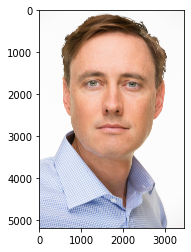

In [92]:
imaa = cv2.imread('/content/gdrive/My Drive/DIM/fg/100.jpg')
imaa = cv2.cvtColor(imaa,cv2.COLOR_BGR2RGB)
plt.imshow(imaa)

In [93]:
PATCH_SIZE = 320
PRETRAINED_PATH = '/content/gdrive/My Drive/DIM/models/model.01-0.0770.hdf5'
TRIMAP_PATH = '/content/gdrive/My Drive/DIM/merged/trimap.jpg'
IMG_PATH = '/content/gdrive/My Drive/DIM/merged/merged.jpg'

In [ ]:
encoder_decoder = build_encoder_decoder()
final = build_refinement(encoder_decoder)
final.load_weights(PRETRAINED_PATH)
# final.summary()

In [94]:
trimap = cv2.imread(TRIMAP_PATH, cv2.IMREAD_GRAYSCALE)
img = cv2.imread(IMG_PATH)
result = np.zeros(trimap.shape, dtype=np.uint8)

In [102]:
x = np.dstack((img, np.expand_dims(trimap, axis=2)))
patches = create_patches(x, PATCH_SIZE)

# create mat for patches predictions
patches_count = np.product(
    patch_dims(mat_size=trimap.shape, patch_size=PATCH_SIZE)
)
patches_predictions = np.zeros(shape=(patches_count, PATCH_SIZE, PATCH_SIZE))

In [103]:
img_size = np.array(trimap.shape)

In [104]:
x = np.dstack((img, np.expand_dims(trimap, axis=2))) / 255.
patches = create_patches(x, PATCH_SIZE)

# create mat for patches predictions
patches_count = np.product(
    patch_dims(mat_size=trimap.shape, patch_size=PATCH_SIZE)
)
patches_predictions = np.zeros(shape=(patches_count, PATCH_SIZE, PATCH_SIZE))

In [124]:
# predicting
for i in range(patches.shape[0]):
    print("Predicting patches {}/{}".format(i + 1, patches_count))

    patch_prediction = final.predict(np.expand_dims(patches[i, :, :, :], axis=0))
    patches_predictions[i] = np.reshape(patch_prediction, (PATCH_SIZE, PATCH_SIZE)) * 255.

Predicting patches 1/187
Predicting patches 2/187
Predicting patches 3/187
Predicting patches 4/187
Predicting patches 5/187
Predicting patches 6/187
Predicting patches 7/187
Predicting patches 8/187
Predicting patches 9/187
Predicting patches 10/187
Predicting patches 11/187
Predicting patches 12/187
Predicting patches 13/187
Predicting patches 14/187
Predicting patches 15/187
Predicting patches 16/187
Predicting patches 17/187
Predicting patches 18/187
Predicting patches 19/187
Predicting patches 20/187
Predicting patches 21/187
Predicting patches 22/187
Predicting patches 23/187
Predicting patches 24/187
Predicting patches 25/187
Predicting patches 26/187
Predicting patches 27/187
Predicting patches 28/187
Predicting patches 29/187
Predicting patches 30/187
Predicting patches 31/187
Predicting patches 32/187
Predicting patches 33/187
Predicting patches 34/187
Predicting patches 35/187
Predicting patches 36/187
Predicting patches 37/187
Predicting patches 38/187
Predicting patches 39

In [125]:
# assemble
result = assemble_patches(patches_predictions, trimap.shape, PATCH_SIZE)
result = result[:img_size[0], :img_size[1]]

prediction = get_final_output(result, trimap).astype(np.uint8)

In [ ]:
# save into files
cv2.imshow("result", prediction)
cv2.imshow("image", img)
cv2.waitKey(0)

In [127]:
prediction.min()

0

In [119]:
prediction = prediction / (prediction.max())

In [120]:
prediction.max()

1.0

In [122]:
# alppppp = alppppp / (alppppp.max())
print('alpha max: {}'.format(alppppp.max()))
trimap = trimap / (trimap.max())
print('trimap max: {}'.format(trimap.max()))

alpha max: 1.0
trimap max: 1.0


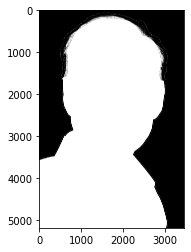

In [108]:
plt.imshow(prediction, cmap='gray')

In [123]:
compute_mse_loss(prediction,alppppp,trimap)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


nan

In [ ]:
fg1 = cv2.imread('/content/gdrive/My Drive/DIM/fg/100.jpg')
bg1 = cv2.imread('/content/gdrive/My Drive/DIM/bg/bg030.jpg')
fg1.shape

(5184, 3456, 3)

In [ ]:
bg1 = cv2.resize(bg1,(3456,5184))

In [100]:
def merge(fg,bg,a):
  a = a / (a.max())
  merged = np.zeros((5184,3456,3))
  for i in tqdm(range(5184)):
    for j in range(3456):
      merged[i,j,0] = a[i,j]*fg[i,j,0] + (1 - a[i,j])*bg[i,j,0]
      merged[i,j,1] = a[i,j]*fg[i,j,1] + (1 - a[i,j])*bg[i,j,1]
      merged[i,j,2] = a[i,j]*fg[i,j,2] + (1 - a[i,j])*bg[i,j,2]
  
  return merged

In [ ]:
catch = merge(fg1,bg1,alppppp)

100%|██████████| 5184/5184 [01:16<00:00, 67.59it/s]


In [109]:
alppppp = cv2.imread('/content/gdrive/My Drive/DIM/alpha/100.jpg',0)

In [ ]:
alppppp.shape

(5184, 3456)

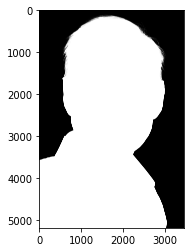

In [110]:
plt.imshow(alppppp,cmap='gray')

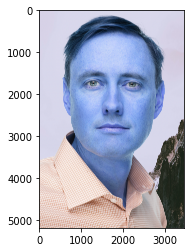

In [ ]:
plt.imshow(catch/255)

In [ ]:
trimap = generate_trimap(alppppp)

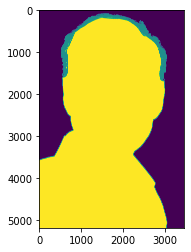

In [ ]:
plt.imshow(trimap)

In [ ]:
compute_mse_loss(prediction,alppppp,trimap)

0.2015863441673334

In [ ]:
prediction = prediction / prediction.max()
prediction.max()

1.0

In [ ]:
alppppp = alppppp / alppppp.max()
alppppp.max()

1.0

In [ ]:
mse = (np.square(alppppp - prediction)).mean(axis=None)

In [ ]:
print(mse)

0.006982178198202037


In [ ]:
alppppp = alppppp * 255
prediction = prediction * 255
print(alppppp.max())
print(prediction.max())

255.0
255.0


In [ ]:
compute_mse_loss(prediction,alppppp,trimap)

0.1559983310103889

In [ ]:
import torch.nn as nn
my_loss = nn.MSELoss()
print("Approx mse loss:",my_loss(prediction, alppppp))

In [96]:
fg1 = cv2.imread('/content/gdrive/My Drive/DIM/fg/100.jpg')
fg1 = cv2.cvtColor(fg1,cv2.COLOR_BGR2RGB)
bg1 = cv2.imread('/content/gdrive/My Drive/DIM/bg/bg030.jpg')
bg1 = cv2.cvtColor(bg1,cv2.COLOR_BGR2RGB)

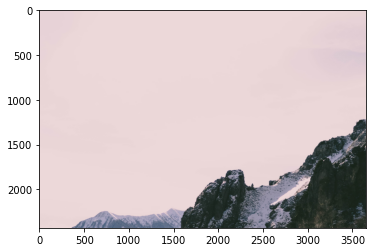

In [97]:
plt.imshow(bg1)

In [98]:
bg1 = cv2.resize(bg1,(3456,5184))

In [101]:
catch = merge(fg1,bg1,alppppp)

NameError: ignored

In [ ]:
catch = catch / catch.max()

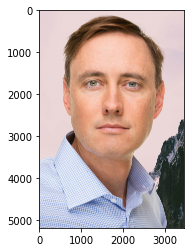

In [ ]:
plt.imshow(catch)

In [ ]:
def multiple(usage,num,imgs,alphas):
  filename = '/content/gdrive/My Drive/DIM/{}.txt'.format(usage)
  with open(filename, 'r') as f:
    names = f.read().splitlines()
  np.random.shuffle(names)

  for i in tqdm(range(num)):
    name = names[i]
    im_name = name.split('_')[0]
    bg_name = name.split('_')[1]
    image, alpha, fg, bg = process(im_name, bg_name)

    different_sizes = [(320, 320), (480, 480), (640, 640)]
    crop_size = random.choice(different_sizes)

    trimap = generate_trimap(alpha)
    x, y = random_choice(trimap, crop_size)
    image = safe_crop(image, x, y, crop_size)
    alpha = safe_crop(alpha, x, y, crop_size)
    fg = safe_crop(fg, x, y, crop_size)
    bg = safe_crop(bg, x, y, crop_size)

    trimap = generate_trimap(alpha)

    imgs[i,:,:,0:3] = image / 255
    imgs[i,:,:,3] = trimap / 255
    alphas[i,:,:,0] = alpha / (alpha.max())

In [ ]:
num = 20
imgs = np.empty((num, img_rows, img_cols, 4), dtype=np.float32)
alphas = np.empty((num,img_rows,img_cols,1),dtype=np.float32)

In [ ]:
multiple('train-09',20,imgs,alphas)

100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


In [ ]:
alphas.shape

(20, 320, 320, 1)

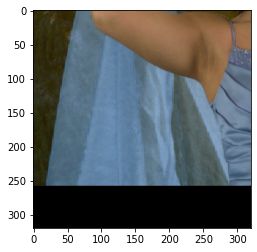

In [ ]:
plt.imshow(imgs[5,:,:,0:3])

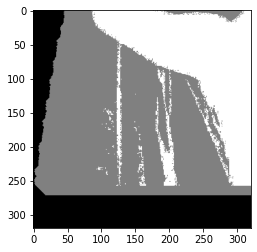

In [ ]:
plt.imshow(imgs[5,:,:,3],cmap='gray')

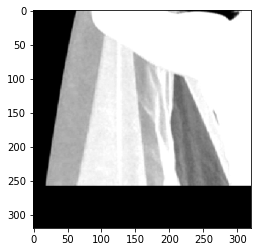

In [ ]:
plt.imshow(alphas[5,:,:,0],cmap='gray')

In [ ]:
imgs.shape

(20, 320, 320, 4)

In [ ]:
def plot_10(imgs,alphas):
  f, axarr = plt.subplots(10,3,figsize=(30,30))

  axarr[0,0].imshow(imgs[1,:,:,0:3])
  axarr[0,1].imshow(imgs[1,:,:,3],cmap='gray')
  axarr[0,2].imshow(alphas[1,:,:,0],cmap='gray')

  axarr[1,0].imshow(imgs[2,:,:,0:3])
  axarr[1,1].imshow(imgs[2,:,:,3],cmap='gray')
  axarr[1,2].imshow(alphas[2,:,:,0],cmap='gray')

  axarr[2,0].imshow(imgs[2,:,:,0:3])
  axarr[2,1].imshow(imgs[2,:,:,3],cmap='gray')
  axarr[2,2].imshow(alphas[2,:,:,0],cmap='gray')

  axarr[3,0].imshow(imgs[3,:,:,0:3])
  axarr[3,1].imshow(imgs[3,:,:,3],cmap='gray')
  axarr[3,2].imshow(alphas[3,:,:,0],cmap='gray')

  axarr[4,0].imshow(imgs[4,:,:,0:3])
  axarr[4,1].imshow(imgs[4,:,:,3],cmap='gray')
  axarr[4,2].imshow(alphas[4,:,:,0],cmap='gray')

  axarr[5,0].imshow(imgs[5,:,:,0:3])
  axarr[5,1].imshow(imgs[5,:,:,3],cmap='gray')
  axarr[5,2].imshow(alphas[5,:,:,0],cmap='gray')

  axarr[6,0].imshow(imgs[6,:,:,0:3])
  axarr[6,1].imshow(imgs[6,:,:,3],cmap='gray')
  axarr[6,2].imshow(alphas[6,:,:,0],cmap='gray')

  axarr[7,0].imshow(imgs[7,:,:,0:3])
  axarr[7,1].imshow(imgs[7,:,:,3],cmap='gray')
  axarr[7,2].imshow(alphas[7,:,:,0],cmap='gray')

  axarr[8,0].imshow(imgs[8,:,:,0:3])
  axarr[8,1].imshow(imgs[8,:,:,3],cmap='gray')
  axarr[8,2].imshow(alphas[8,:,:,0],cmap='gray')

  axarr[9,0].imshow(imgs[9,:,:,0:3])
  axarr[9,1].imshow(imgs[9,:,:,3],cmap='gray')
  axarr[9,2].imshow(alphas[9,:,:,0],cmap='gray')

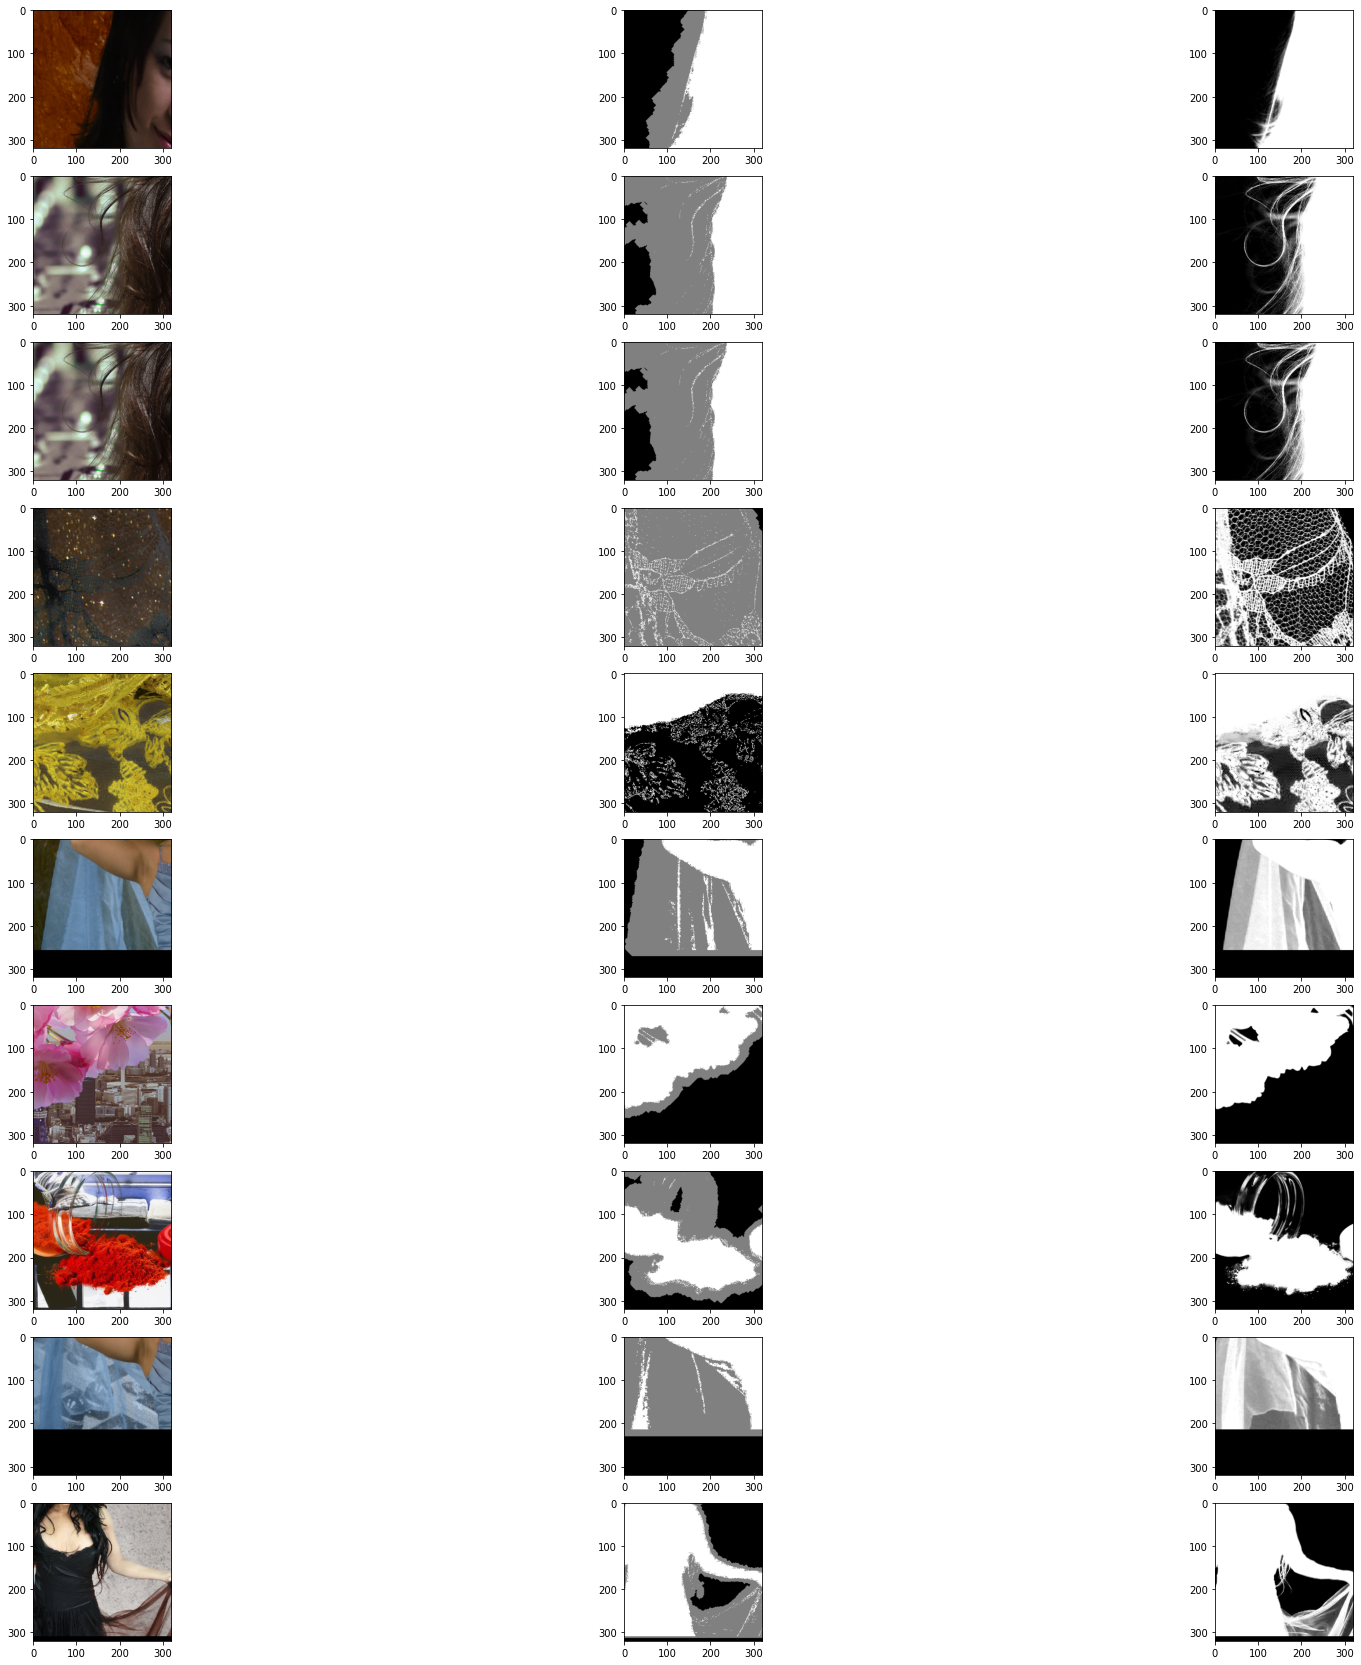

In [ ]:
plot_10(imgs,alphas)

In [ ]:
def predict_patches(num,x):
  patches_pred = np.zeros(shape=(num, 320,320))
  for i in range(num):
    print('Predicting patches: patch {}/{}'.format(i+1,num))
    patch_pred = final.predict(np.expand_dims(x[i,:,:,:],axis=0))
    patches_pred[i] = np.reshape(patch_pred,(320,320)) 
  return patches_pred

In [ ]:
preds = predict_patches(20,imgs)

Predicting patches: patch 1/20

Predicting patches: patch 2/20
Predicting patches: patch 3/20
Predicting patches: patch 4/20
Predicting patches: patch 5/20
Predicting patches: patch 6/20
Predicting patches: patch 7/20
Predicting patches: patch 8/20
Predicting patches: patch 9/20
Predicting patches: patch 10/20
Predicting patches: patch 11/20
Predicting patches: patch 12/20
Predicting patches: patch 13/20
Predicting patches: patch 14/20
Predicting patches: patch 15/20
Predicting patches: patch 16/20
Predicting patches: patch 17/20
Predicting patches: patch 18/20
Predicting patches: patch 19/20
Predicting patches: patch 20/20


In [ ]:
preds.shape

(20, 320, 320)

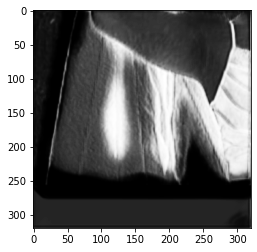

In [ ]:
plt.imshow(preds[5,:,:],cmap='gray')

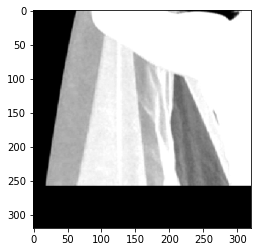

In [ ]:
plt.imshow(alphas[5,:,:,0],cmap='gray')

In [ ]:
def mse_compute(target,pred,num):
  mse = 0
  t = np.reshape(target,(num,320,320))
  for i in tqdm(range(num)):
    mse += (np.square(t - pred)).mean(axis=None)
  return mse/num

In [ ]:
mse_compute(alphas,preds,20)

100%|██████████| 20/20 [00:00<00:00, 135.00it/s]


0.23622881351909095